---
**Code Testing**

Week 16 of EMAT30008

https://engmaths.github.io/emat30008/odes/codetesting/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# We import our functions from our own package
from scicomp.odefunctions import *

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---------
We test the `limit_cycle_condition` and `find_limit_cycle` functions developed in Week 15

We find a key error: inside of `find_limit_cycle`, our root finder may test very small limit cycle periods which are less than the step size `deltat_max` used by `solve_to`. This leads to an error being thrown, and so the function cannot find a limit cycle.

We need a way of restricting the domain which `scipy.optimize.root` tests over, but there is no such functionality developed by scipy. Most other readily available root finding functions don't allow for a restricted domain. However, most minimisation functions do allow for this, and so we might choose to convert to a minmisation problem.

We convert the problem into a minimisation problem by establishing an objective function that sums the squares of all variables in G_collection and phi. We can then use bounded minimization solvers from scipy.

-----------
We rewrite our functions:

We create `limit_cycle_condition_min`, in which we define an objective function, which is minimised in `find_limit_cycle_min`.
This objective function has the following form:

$\text{Objective} = \frac{\sum \limits_{i=1}^{ N} G_i(u_0, T)^2}{ N}  + 10 \ \text{phi}(u_0, T)^2 + \alpha T$

This is the mean squared error of all the $G_i$ and phi, with a regularisation on period $T$ which acts to minimise the period. In some cases a period of $20$ may be reported when the true period is $10$, which this regularisation tries to address.

In [2]:
def limit_cycle_condition_min(ode_func,
                          params: np.ndarray, 
                          num_loops_needed: int = 10,
                          phase_condition: Literal['constant', 'derivative']='derivative',
                          constant_value: float = None,
                          deltat_max: float = 0.01):
    
    # Error Messages
    if num_loops_needed < 1:
        raise Exception("Please specify a positive number of loops needed.")
    if not (phase_condition in ['constant', 'derivative']):
        raise Exception("Input Error: Please supply a valid phase condition.")
    if phase_condition == 'constant' and constant_value == None:
        raise Exception("Input Error: Please supply a starting value that the first state variable must attain.")

    # Extract T, u0 from params
    T, u0 = params[0], params[1:]

    # Establish empty array to hold Gs
    num_variables = len(u0)
    G_collection = np.zeros([num_loops_needed*num_variables])

    # Loop over number of loops checked
    for i in range(num_loops_needed):
        # Compute G by calling the solver to solve until time (i+1)*T. Solve with RK4 and deltat_max supplied
        solution = solve_to(ode_func=ode_func, x_init=u0, t_init=0, 
                            t_final=(i+1)*T, deltat_max=deltat_max, method='RK4')
        uT = solution[-1,1:]
        G = u0 - uT
        G_collection[i*num_variables:(i+1)*num_variables] = G
    
    # Compute phi 
    if phase_condition == 'constant':
        # Compute difference between first state variable at time t=0 and constant_value
        phi = u0[0] - constant_value
    elif phase_condition == 'derivative':
        # Compute derivative of first state variable at time t=0
        u0dot = ode_func(u0, 0)
        phi = u0dot[0]

    # Introduce a regularisation constant for the period in our objective function
    alpha = 1e-5

    # Return sum of squares of G_collection and phi, plus the period times some weight
    return np.sum(np.square(G_collection))/len(G_collection) + 10*phi**2 + alpha*T

In [3]:
# Testing this function
import numpy as np
def shm(x, t):
    return np.array(([x[1], -x[0]]))
objective = limit_cycle_condition_min(shm, np.array(([1,3,3])), 10, 'constant', 2)
print(objective)

30.551415942882745


We then create `find_limit_cycle_min` to specify a bound on the limit cycle period so that it isn't below our supplied `deltat_max`. Then we pass the `limit_cycle_condition_min`, with the ODE function and other attributes set, into scipy's minimize function.

In [4]:
def find_limit_cycle_min(ode_func, 
                     init_point_guess: np.ndarray,
                     init_period_guess: float,
                     num_loops_needed: int = 1,
                     phase_condition: Literal['constant', 'derivative']='derivative',
                     constant_value: float = None,
                     deltat_max: float = 0.01,
                     print_findings: bool = True):
    
    # Error Messages
    if init_period_guess <= deltat_max:
        raise Exception("Initial period guess is less than step size.")
    
    # Establish lambda function for use with scipy.optimize.root, means we only vary params
    objective_function = lambda params: limit_cycle_condition_min(ode_func=ode_func,
                                                              num_loops_needed=num_loops_needed,
                                                              params = params,
                                                              phase_condition=phase_condition,
                                                              constant_value=constant_value,
                                                              deltat_max=deltat_max)


    # Pack init_point_guess and init_period_guess into params
    init_params = np.concatenate(([init_period_guess], init_point_guess))
    
    # Specify lower bound for limit cycle period to be greater than 10*deltatmax
    bounds = [(10*deltat_max, None)] + [(None,None) for i in range(len(init_point_guess))]

    # Minimize the limit cycle objective function with above bounds and initial guess
    result = minimize(fun=objective_function, x0=init_params, bounds=bounds)

    # If objective function value too large we deem the result a failure
    # Note if the actual period is larger than 1/alpha in our objective function
    # then any attempt will be deemed a failure.
    if objective_function(result.x) > 1:
        if print_findings:
            print("No limit cycle was found (failed to converge).")
        return None, None

    if result.success:
        best_period, best_point = result.x[0], result.x[1:]
        if print_findings:
            print("A limit cycle was found:")
            print("Period:", round(best_period,2), ",")
            print("Starting state:", [round(i,2) for i in best_point], ".")
        return best_period, best_point
    else:
        if print_findings:
            print("No limit cycle was found (failed to converge).")
        return None, None

--------
**Unit Test**

Test against a basic SHM ODE.

In [5]:
# We define a basic SHM function, and redefine our ODE quick plotter from week 15
def shm(x, t):
    return np.array(([x[1], -x[0]]))

def ode_quick_plot(ode_func, init_state, t_final=200, step=0.1):
    # Just for quick testing, not rigorous
    solution = solve_to(ode_func, init_state, 0, t_final, step, 'RK4')

    plt.figure(figsize=[12,8])
    plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
    plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
    plt.legend()
    plt.title("State variables over time")
    plt.xlabel("Time")
    plt.ylabel("Variable value")
    plt.grid()
    plt.show()

    plt.figure(figsize=[12,8])
    plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
    plt.title("Phase space plot")
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")
    plt.grid()
    plt.show()
    return None

A limit cycle was found:
Period: 12.57 ,
Starting state: [2.56, -0.0] .


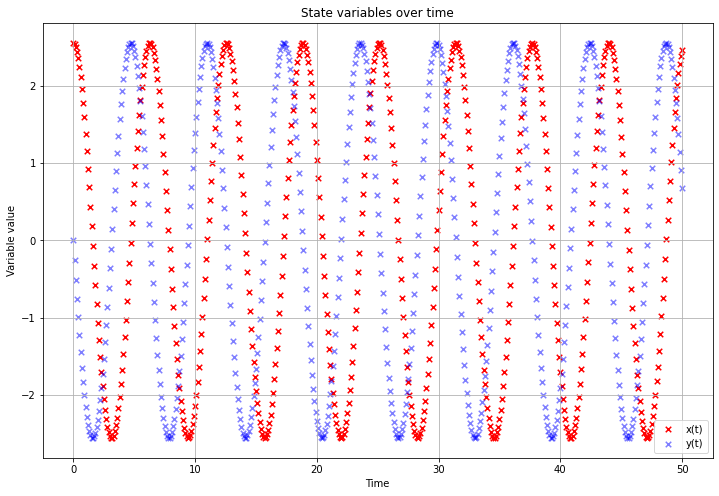

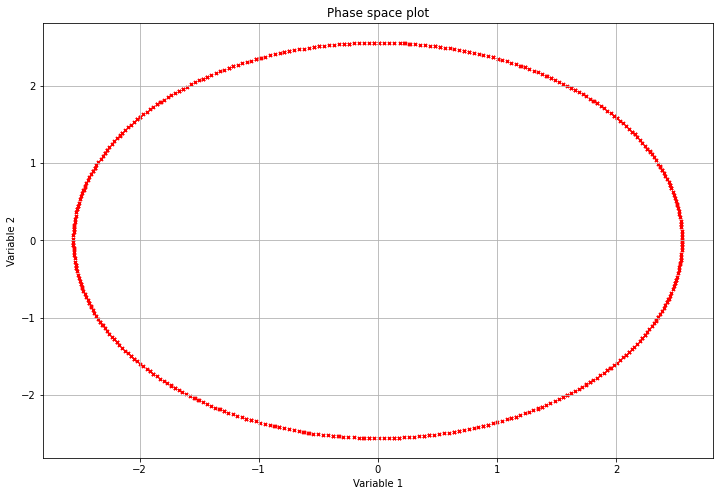

In [6]:
period, start_point = find_limit_cycle_min(shm, np.array(([5,1])), 10, 1)
ode_quick_plot(shm, start_point, 50)

------------
**Unit test**

We now check against the Hopf bifurcation normal form

$\frac{d u_1}{dt} = \beta u_1 - u_2 + \sigma u_1 (u_1^2 + u_2^2)$

$\frac{d u_2}{dt} = u_1 + \beta u_2 + \sigma u_2 (u_1^2 + u_2^2)$

For $\sigma = -1$ we get the analytical solution
$u_1(t) = \sqrt{\beta} cos(t + \theta)$

$u_2(t) = \sqrt{\beta} cos(t + \theta)$

Where $\theta$ is the phase.


We search for a limit cycle, and test that this has a period of $2\pi$, and a start point with
euclidean magnitude $\beta$:


A limit cycle was found:
Period: 6.28 ,
Starting state: [1.41, 0.0] .
Test passed.
Test passed.


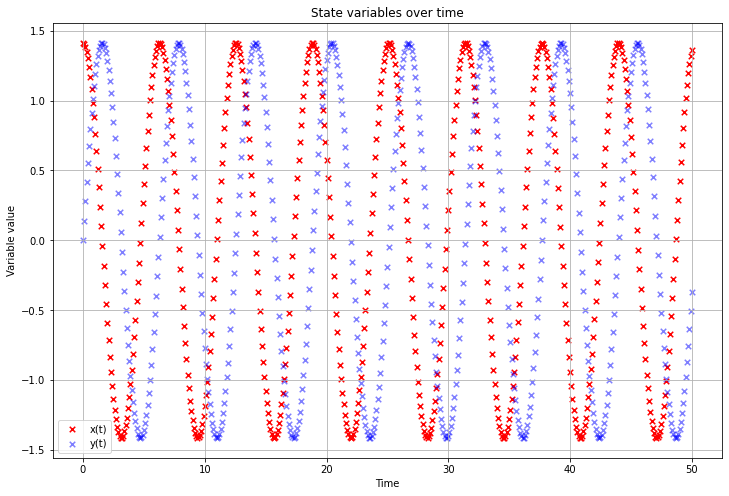

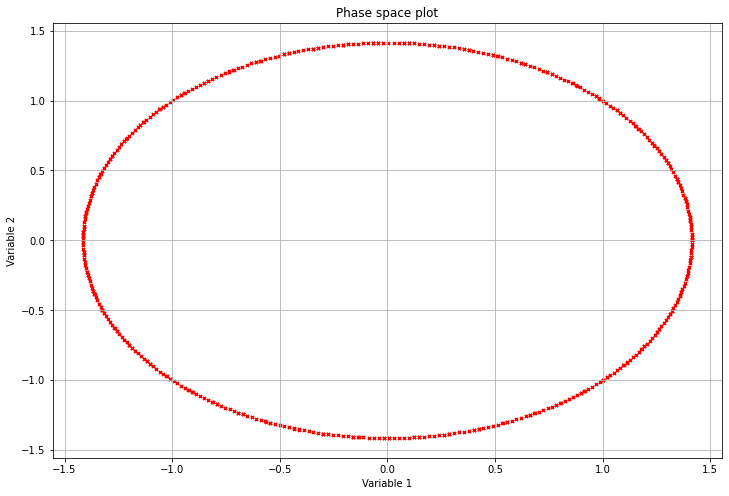

In [7]:
# Define hopf bifurcation normal form ODE function
def hopf_ode(x, t):
    beta = 2 # Chosen arbitrarily
    sigma = -1
    u1, u2 = x[0], x[1]
    du1dt = beta*u1 - u2 + sigma*u1*(u1**2 + u2**2)
    du2dt = u1 + beta*u2 + sigma*u2*(u1**2 + u2**2)
    return np.array(([du1dt, du2dt]))

# We then expect a period of 2pi from our limit cycle, and a magnitude of sqrt(Beta)
init_point_guess = np.array(([1,1]))
init_period_guess = 6 # (Close to 2pi=6.28)

period, start_point = find_limit_cycle_min(hopf_ode, init_point_guess, init_period_guess)

if abs(period - 2*np.pi) < 1e-5:
    print("Test passed.")
else:
    print("Test failed.")

if abs(np.sqrt(2) - np.sqrt(np.sum(np.square(start_point))))<1e-5:
    print("Test passed.")
else:
    print("Test failed.")

ode_quick_plot(hopf_ode, start_point, 50)

----------
**Unit test**

We test against a non-autonomous ODE: Forced SHM

$\frac{d^2 x}{d t^2} + C\frac{dx}{dt} + x + f(t) = 0 $

where $f(t)=A(1+cos(\frac{2 \pi t}{B}))$ is our forcing function, $A$ is the forcing amplitude, $B$ is the forcing period, and $C$ is the damping.

A limit cycle was found:
Period: 20.32 ,
Starting state: [5.18, 0.0] .


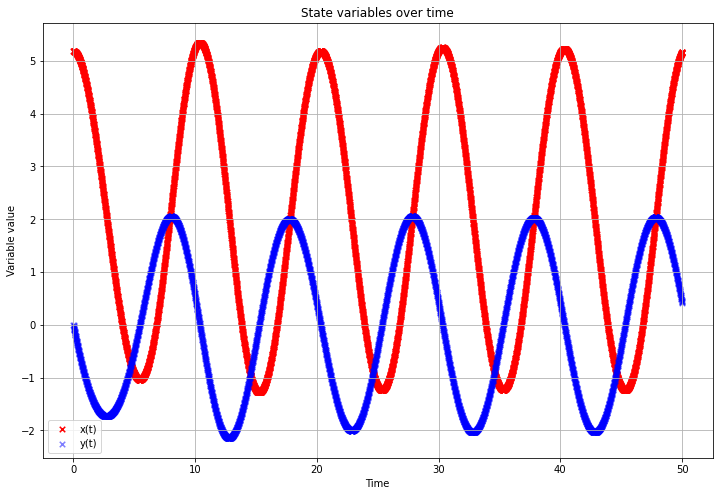

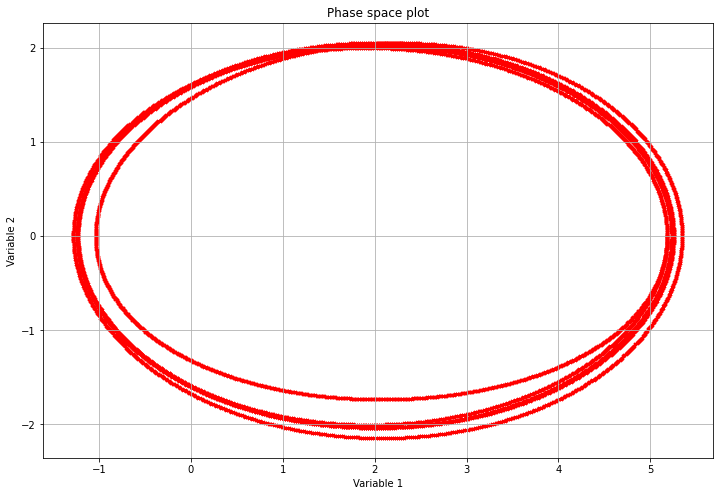

In [8]:
# Define forced SHM ode
def forced_shm(x,t):
    damping = 0.2
    forcing_amplitude = 2
    forcing_period = 10
    s = x[0]
    v = x[1]
    a = -s  + -damping*v + forcing_amplitude*(1+ np.cos(t*(2*np.pi)/forcing_period))
    return np.array(([v,a]))

# Try to find a limit cycle
period, start_point = find_limit_cycle_min(forced_shm, np.array(([5,0])), 20, 1)
ode_quick_plot(forced_shm, start_point, t_final=50, step=0.01)

Here a period of ~20 is found, but the period we want is ~10. This might be addressed by increasing the regularisation constant $\alpha$ within our `limit_cycle_condition_min` function's objective function.

----------
**Unit test**

We now test the code for throwing errors.

Start with when the dimensions for the initial condition and ode function don't match:

In [10]:
period, start_point = find_limit_cycle_min(forced_shm, np.array(([5,0,8])), 20, 1)

Exception: ODE function and initial condition dimensions do not match.

We test the case where no root is found, by setting a high constant value for the constant phase condition which cannot be obtained:

In [11]:
period, start_point = find_limit_cycle_min(hopf_ode, np.array(([12,-6])), 10, 1, phase_condition='constant', constant_value=200)
print("Period: ", period)
print("Initial values:", start_point)

/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_20586/2371075320.py:6: RuntimeWarning: overflow encountered in scalar power
  du1dt = beta*u1 - u2 + sigma*u1*(u1**2 + u2**2)
/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_20586/2371075320.py:7: RuntimeWarning: overflow encountered in scalar power
  du2dt = u1 + beta*u2 + sigma*u2*(u1**2 + u2**2)
/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_20586/2371075320.py:6: RuntimeWarning: invalid value encountered in scalar add
  du1dt = beta*u1 - u2 + sigma*u1*(u1**2 + u2**2)
/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_20586/2371075320.py:7: RuntimeWarning: invalid value encountered in scalar add
  du2dt = u1 + beta*u2 + sigma*u2*(u1**2 + u2**2)
/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_20586/2371075320.py:6: RuntimeWarning: overflow encountered in scalar multiply
  du1dt = beta*u1 - u2 + sigma*u1*(u1**2 + u2**2)
/var/folders/r2/3w7vkj3n6z5c55vp_fm676380000gn/T/ipykernel_20586/2

No limit cycle was found (failed to converge).
Period:  None
Initial values: None


----------
Full docstrings can be found on `odefunctions.py`, where our finished functions are deposited.


There is still further work to do to design a better limit cycle finder
- Better conditions could be designed to ensure that limit cycles are found.
- Sometimes equillibrium solutions are found, rather than limit cycles, when using a derivative phase condition. Work could be done to check for equillibrium and discard this.
- Minimisation may be a much slower approach than root finding, it is only used to be able to bound the period guesses. Instead we could find a root finding algorithm that allows for constraints on the parameters it searches over.
- We might investigate the high sensitivity to initial guesses, and make a system which takes many initial guesses over a parameter grid and reports the best result.